# <b>Prediction of Wild Blueberry Yield</b>

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os

# Scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ML model
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [ ]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: yield<br>
`test.csv`: 테스트 데이터 <br>

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


### 2-1. 데이터 설명

In [ ]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [ ]:
data_describe(train_df, 'Train')

====================== Train Data Describe ======================
Row: 15289, Column: 18
                  Column    Dtype  Unique levels  Missing Count
0                     id    int64          15289              0
1              clonesize  float64              6              0
2               honeybee  float64              7              0
3                bumbles  float64             11              0
4                andrena  float64             16              0
5                  osmia  float64             14              0
6       MaxOfUpperTRange  float64              6              0
7       MinOfUpperTRange  float64              5              0
8   AverageOfUpperTRange  float64              5              0
9       MaxOfLowerTRange  float64              6              0
10      MinOfLowerTRange  float64              7              0
11  AverageOfLowerTRange  float64              5              0
12           RainingDays  float64              6              0
13    AverageRa

In [ ]:
train_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [ ]:
data_describe(test_df, 'Test')

====================== Test Data Describe ======================
Row: 10194, Column: 17
                  Column    Dtype  Unique levels  Missing Count
0                     id    int64          10194              0
1              clonesize  float64              5              0
2               honeybee  float64              7              0
3                bumbles  float64              8              0
4                andrena  float64             12              0
5                  osmia  float64             14              0
6       MaxOfUpperTRange  float64              7              0
7       MinOfUpperTRange  float64              6              0
8   AverageOfUpperTRange  float64              6              0
9       MaxOfLowerTRange  float64              5              0
10      MinOfLowerTRange  float64              5              0
11  AverageOfLowerTRange  float64              5              0
12           RainingDays  float64              6              0
13    AverageRai

In [ ]:
test_df.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [ ]:
X_train = train_df.drop(['id', 'yield'], axis=1)
y_train = train_df['yield']

X_test = test_df.drop(['id'], axis=1)

## 3. EDA & Preprocessing

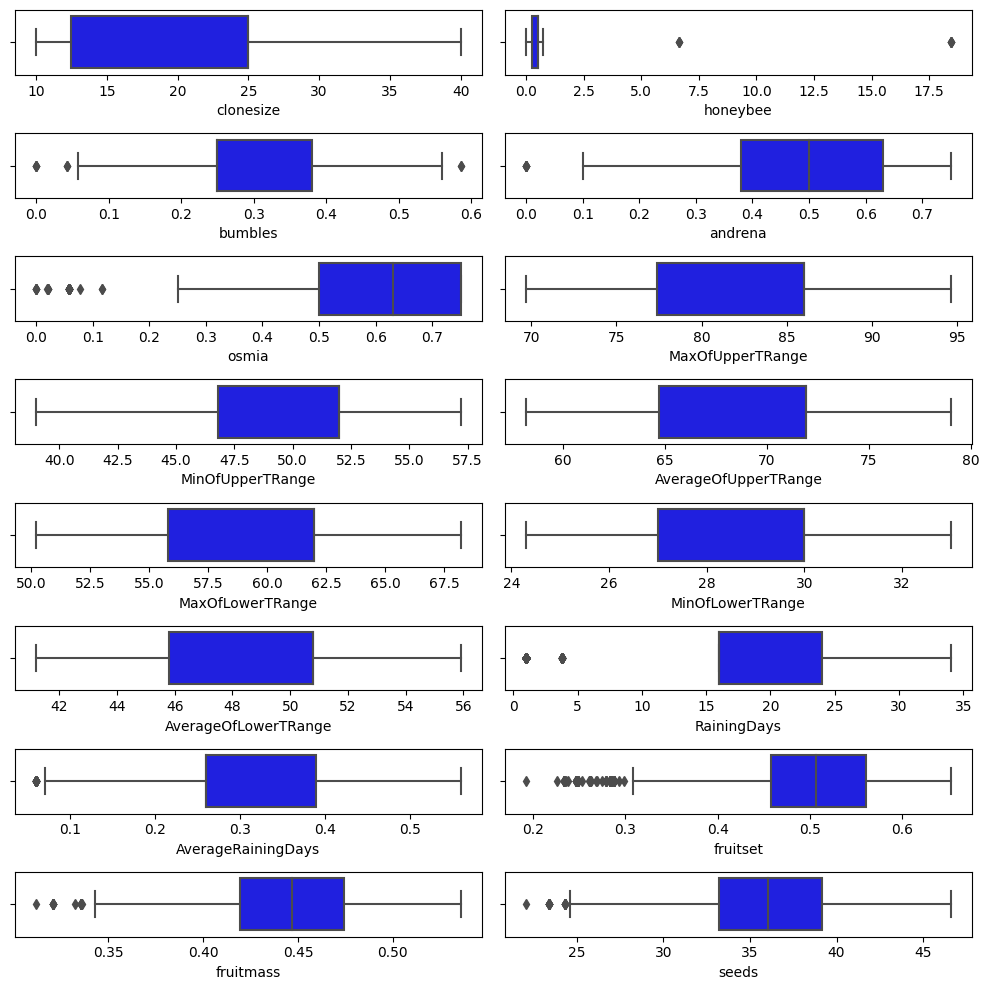

In [ ]:
fig  = plt.figure(figsize=(10, 10))
for idx, column in enumerate(X_train.select_dtypes(exclude='object').columns):
    fig.add_subplot(8, 2, idx+1)
    ax = sns.boxplot(x=X_train[column], color='blue')
    ax.set_xlabel(column, fontsize=10)
plt.tight_layout()
plt.show()

### 3-1. 이상치 제거

In [ ]:
# Remove Outliers: 이상치 제거
def drop_outliers(df):
    df.drop(df[df.honeybee > 2.5].index, axis=0, inplace=True)
    df.drop(df[(df.bumbles < 0.05) | (df.bumbles > 0.55)].index, axis=0, inplace=True)
    df.drop(df[(df.andrena < 0.1)].index, axis=0, inplace=True)
    df.drop(df[(df.osmia < 0.2)].index, axis=0, inplace=True)
    df.drop(df[(df.RainingDays < 5)].index, axis=0, inplace=True)
    df.drop(df[(df.AverageRainingDays < 0.08)].index, axis=0, inplace=True)
    df.drop(df[(df.fruitset < 0.3)].index, axis=0, inplace=True)
    df.drop(df[(df.fruitmass < 0.33)].index, axis=0, inplace=True)
    df.drop(df[(df.seeds < 25) | (df.seeds > 50)].index, axis=0, inplace=True)

In [ ]:
# 해당 train 데이터는 postprocessor 함수에서 사용됨
train = pd.concat([X_train, y_train], axis=1)
drop_outliers(train)

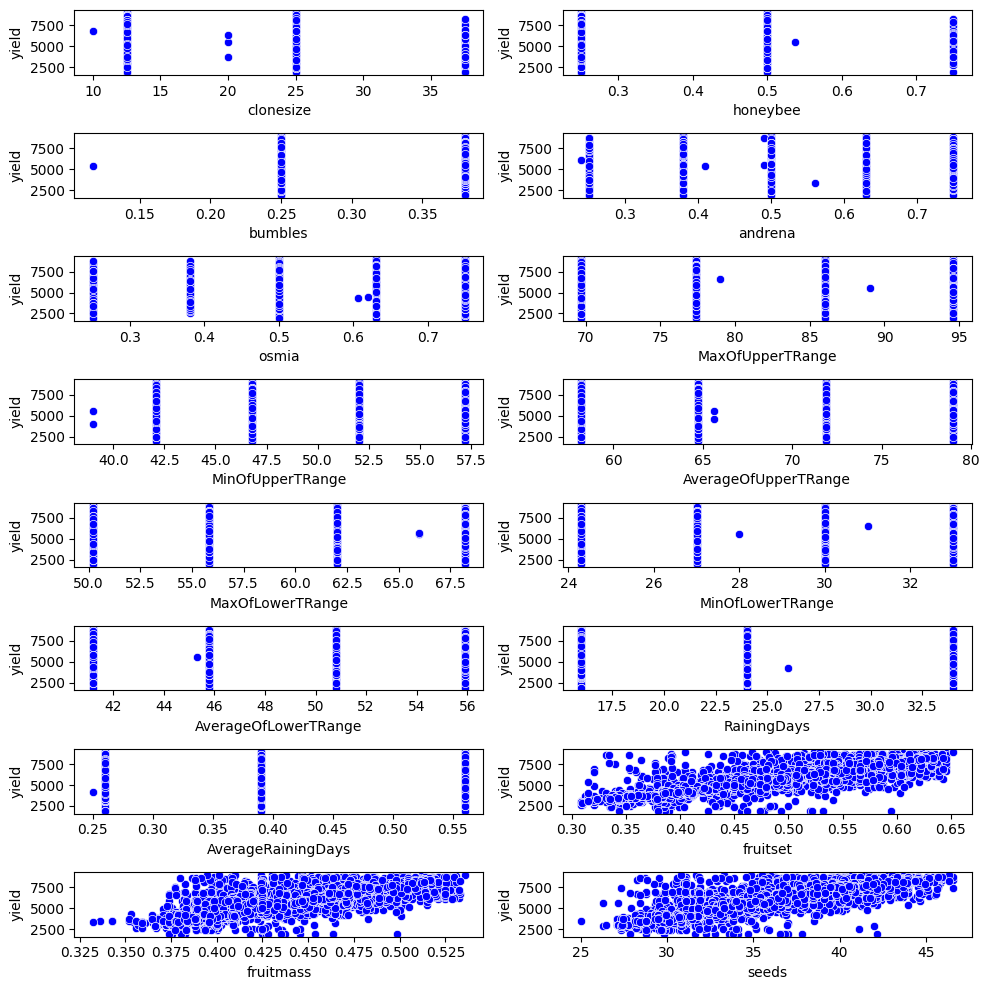

In [ ]:
fig  = plt.figure(figsize=(10, 10))
for idx, column in enumerate(train.drop('yield', axis = 1).select_dtypes(exclude='object').columns):
    fig.add_subplot(8, 2, idx+1)
    ax = sns.scatterplot(x=train[column], y=train['yield'], color='blue')
    ax.set_xlabel(column, fontsize=10)
plt.tight_layout()
plt.show()

### 3-2. Correlation map

In [ ]:
def show_corr_heatmap(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(15, 10))
    plt.title(title)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', vmax=1, vmin=-1,
                square=True, mask = mask, cmap='RdYlBu_r')
    plt.show()

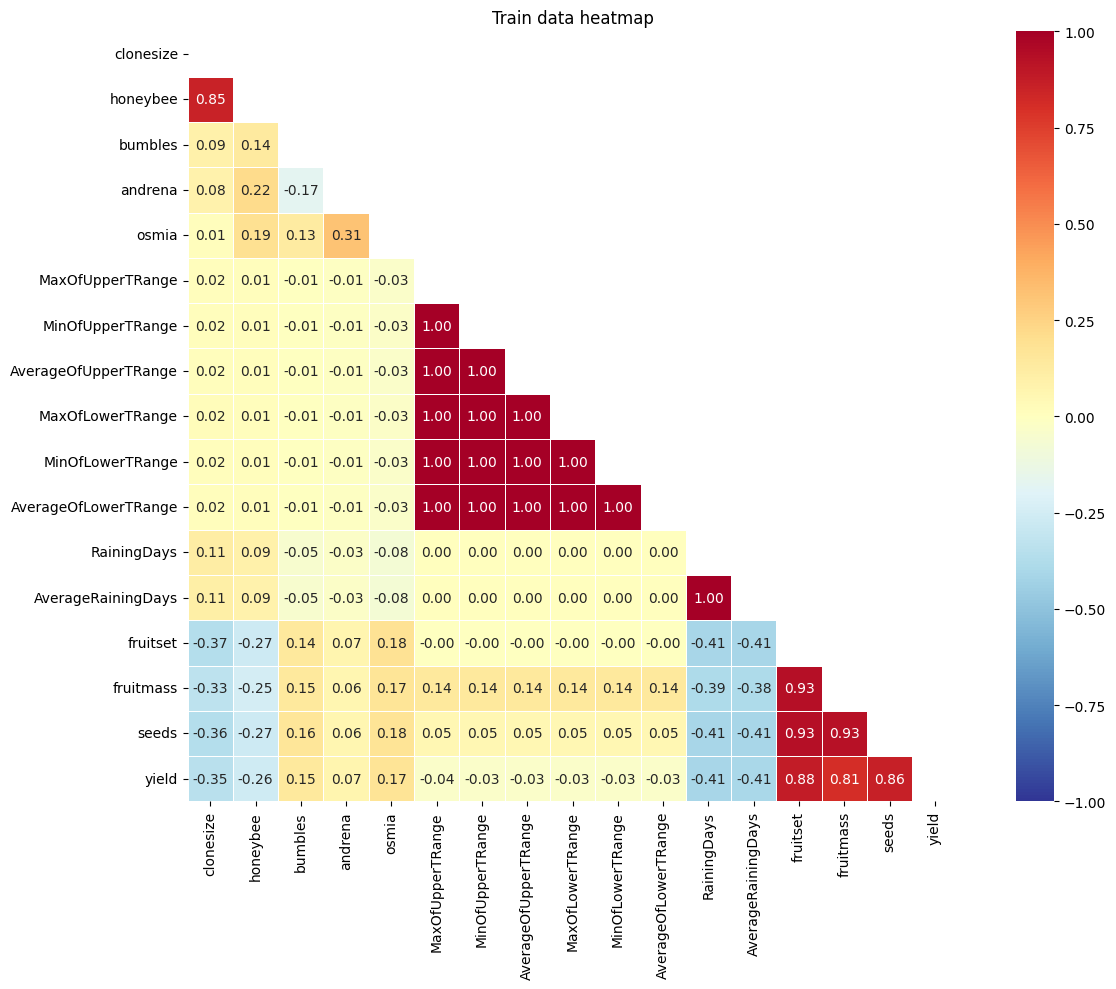

In [ ]:
show_corr_heatmap(train, 'Train data heatmap')

### 3-3. Feature Engineering

In [ ]:
def fe(df):
    df['TemperatureRange'] = df['MaxOfUpperTRange'] - df['MinOfLowerTRange']
    df['RainIntensity'] = df['AverageRainingDays'] / df['RainingDays']
    df['FruitSeed'] = df['fruitset'] * df['seeds']

In [ ]:
fe(X_train)
fe(X_test)

In [ ]:
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

### 3-4. PCA Feature 추가

In [ ]:
def add_pca_features(X_train, X_test):

    # Select the columns for PCA
    pca_features = X_train.select_dtypes(include=['float64']).columns.tolist()
    n_components = 2 # len(pca_features)

    # Create the pipeline
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=n_components))

    # Perform PCA
    pipeline.fit(X_train[pca_features])

    # Create column names for PCA features
    pca_columns = [f'PCA_{i}' for i in range(n_components)]

    # Add PCA features to the dataframe
    X_train[pca_columns] = pipeline.transform(X_train[pca_features])
    X_test[pca_columns] = pipeline.transform(X_test[pca_features])

    return X_train, X_test

In [ ]:
X_train, X_test = add_pca_features(X_train, X_test)

In [ ]:
X_train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,...,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,TemperatureRange,RainIntensity,FruitSeed,PCA_0,PCA_1
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,...,24.0,0.39,0.425011,0.417545,32.460887,45.4,0.01625,13.796231,3.843216,1.752222
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,...,24.0,0.39,0.444908,0.422051,33.858317,45.4,0.01625,15.063846,3.780226,1.401241
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,...,24.0,0.39,0.552927,0.470853,38.341781,56.0,0.01625,21.200199,-1.231036,-0.681825
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,...,24.0,0.39,0.565976,0.478137,39.467561,50.4,0.01625,22.337712,1.168979,-1.235760
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,...,24.0,0.39,0.579677,0.494165,40.484512,50.4,0.01625,23.467926,1.120756,-1.352903


In [ ]:
X_test.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,...,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,TemperatureRange,RainIntensity,FruitSeed,PCA_0,PCA_1
0,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,...,24.0,0.39,0.399367,0.408088,31.394569,56.0,0.01625,12.537955,-0.791147,3.003106
1,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,...,1.0,0.10,0.488048,0.442866,36.846956,61.6,0.10000,17.983080,-3.630076,-1.197584
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,...,16.0,0.26,0.583379,0.487057,40.037644,56.0,0.01625,23.357110,-1.366582,-1.859365
3,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,...,16.0,0.26,0.433014,0.422847,33.116091,56.0,0.01625,14.339741,-0.916121,1.425277
4,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,...,24.0,0.39,0.360996,0.388860,29.558019,61.6,0.01625,10.670317,-3.110266,4.526631


### 3-5. 데이터 스케일링: StandardScaler

In [ ]:
numeric_columns = [_ for _ in X_train.columns]

sc = StandardScaler()
X_train[numeric_columns] = sc.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = sc.transform(X_test[numeric_columns])

### 3-6. 불필요한 컬럼 삭제

In [ ]:
to_drop = ['MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange',
           'MinOfLowerTRange', 'AverageOfLowerTRange', 'AverageRainingDays',
           'honeybee', 'bumbles', 'andrena','osmia']

X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

## 4. Train Model
- 평가지표: `Mean Absolute Error(MAE)`

### 4-1. Train LightGBM Model

In [ ]:
def LightGBM(X, y, test_data, params):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    preds, models = [], []
    oof = np.zeros(len(X))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print("-"*30, "fold:", fold, "-"*30)

        # set train/valid data
        x_tr, y_tr = X.iloc[train_idx, :], y.iloc[train_idx]
        x_va, y_va = X.iloc[val_idx, :], y.iloc[val_idx]

        train_data = lgb.Dataset(x_tr, label=y_tr)
        val_data = lgb.Dataset(x_va, label=y_va)

        # Train model with early stopping
        model = lgb.train(params, train_data,
                          valid_sets=[train_data, val_data],
                         verbose_eval=False)

        models.append(model)

        # validation
        pred_va = model.predict(x_va)
        oof[val_idx] = pred_va
        print("MAE(valid)", fold, ":", "{:.4f}".format(mean_absolute_error(y_va, pred_va)))

        # prediction
        pred_test = model.predict(test_data)
        preds.append(pred_test)

    return preds, models, oof

In [ ]:
lgb_params = {'objective':'regression_l1',
              'learning_rate': 0.04,
              'max_bin': 1000,
              'colsample_bytree': 0.8,
              'subsample': 0.7,
              'bagging_freq': 1,
              'metric': 'mae',
              'n_estimators': 2000,
              'verbosity': -1,
              'n_jobs': -1}

In [ ]:
print('X_train Columns: \n', X_train.columns)

X_train Columns: 
 Index(['clonesize', 'MaxOfUpperTRange', 'RainingDays', 'fruitset', 'fruitmass',
       'seeds', 'TemperatureRange', 'RainIntensity', 'FruitSeed', 'PCA_0',
       'PCA_1'],
      dtype='object')


In [ ]:
print('X_test Columns: \n', X_test.columns)

X_test Columns: 
 Index(['clonesize', 'MaxOfUpperTRange', 'RainingDays', 'fruitset', 'fruitmass',
       'seeds', 'TemperatureRange', 'RainIntensity', 'FruitSeed', 'PCA_0',
       'PCA_1'],
      dtype='object')


In [ ]:
preds_lgb_fe, models_lgb_fe, oof_lgb_fe = LightGBM(X_train, y_train, X_test, lgb_params)

# MAE for LightGBM
oof_lgb = np.zeros(len(y_train))

oof_lgb_round = np.zeros(len(oof_lgb), dtype=int)
for i in range(len(oof_lgb)):
    oof_lgb_round[i] = int((oof_lgb_fe[i] * 2 + 1) // 2)

print("MAE(int):", "{:.4f}".format(mean_absolute_error(y_train, oof_lgb_round)))
print("MAE(float):", "{:.4f}".format(mean_absolute_error(y_train, oof_lgb_fe)))

# visualization of predictions by test-data
mean_preds_lgb = np.mean(preds_lgb_fe, axis=0)
mean_preds_lgb_round = np.zeros(len(mean_preds_lgb), dtype=int)
for i in range(len(mean_preds_lgb_round)):
    mean_preds_lgb_round[i] = int((mean_preds_lgb[i] * 2 + 1) // 2)

------------------------------ fold: 0 ------------------------------
MAE(valid) 0 : 331.5998
------------------------------ fold: 1 ------------------------------
MAE(valid) 1 : 347.2404
------------------------------ fold: 2 ------------------------------
MAE(valid) 2 : 364.3750
------------------------------ fold: 3 ------------------------------
MAE(valid) 3 : 354.4272
------------------------------ fold: 4 ------------------------------
MAE(valid) 4 : 329.3778
------------------------------ fold: 5 ------------------------------
MAE(valid) 5 : 346.1528
------------------------------ fold: 6 ------------------------------
MAE(valid) 6 : 344.6170
------------------------------ fold: 7 ------------------------------
MAE(valid) 7 : 331.4174
------------------------------ fold: 8 ------------------------------
MAE(valid) 8 : 350.7355
------------------------------ fold: 9 ------------------------------
MAE(valid) 9 : 342.3200
MAE(int): 344.2263
MAE(float): 344.2264


## 5. Submission

In [ ]:
def postprocessor(prediction):
    unique_targets = np.unique(train['yield']) # 이상치를 제거한 train['yield']를 사용함
    return [min(unique_targets, key = lambda x: abs(x - pred)) for pred in prediction]

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission['yield'] = postprocessor(mean_preds_lgb_round)
submission.to_csv('submission.csv', index=False)

submission.head()

,id,yield
0,15289,4278.76321
1,15290,5837.21503
2,15291,7270.31832
3,15292,4590.82334
4,15293,3866.79896
